In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [2]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

def get_count(path,set_):
    
    dict_ = {}
    
    for exp in os.listdir(path):
        
        dir_ = path + exp
        dict_[exp] = len(os.listdir(dir_))
        
    df = pd.DataFrame(dict_,index=[set_])
    
    return df
    

train_count = get_count(train_dir,'train')
test_count = get_count(test_dir,'test')

print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


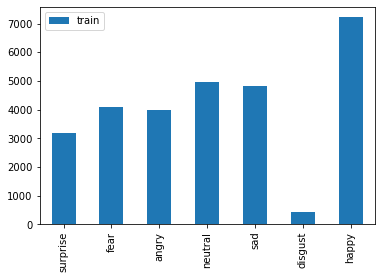

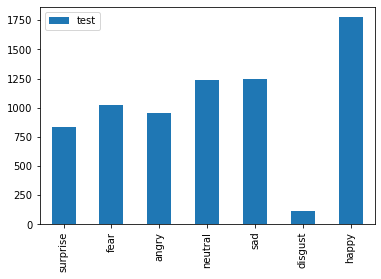

In [3]:
train_count.transpose().plot(kind = 'bar')
test_count.transpose().plot(kind = 'bar')

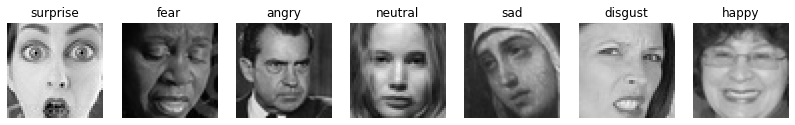

In [4]:
plt.figure(figsize=(14,22))
i = 1

for exp in os.listdir(train_dir):
    
    img = load_img((train_dir + exp + '/' + os.listdir(train_dir + exp)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
#     print(img.size)
    plt.title(exp)
    plt.axis('off')
    i += 1
    
plt.show()

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.3,horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                 batch_size=64,
                                                 target_size=(48,48),
                                                 shuffle=True,
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

testing_set = test_datagen.flow_from_directory(test_dir,
                                                 batch_size=64,
                                                 target_size=(48,48),
                                                 shuffle=True,
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
# training_set.class_indices
testing_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [7]:
def get_model(input_size,classes=7):
    
    #initialising The CNN
    
    model = tf.keras.models.Sequential()
    
    model.add(Conv2D(32,
                     kernel_size=(3,3),
                     padding = 'same', 
                     activation = 'relu',
                     input_shape = input_size))
    
    model.add(Conv2D(64, 
                     kernel_size=(3,3),
                     padding='same',
                     activation='relu'))
    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, 
                     kernel_size=(3,3),
                     padding='same',
                     activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)))
    
    model.add(Conv2D(256, 
                     kernel_size=(3,3),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)))
    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same',
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same',
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes,activation='softmax'))
    
    model.compile(optimizer=Adam(lr=0.0001,decay=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
fernet = get_model((48,48,1),7)
fernet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

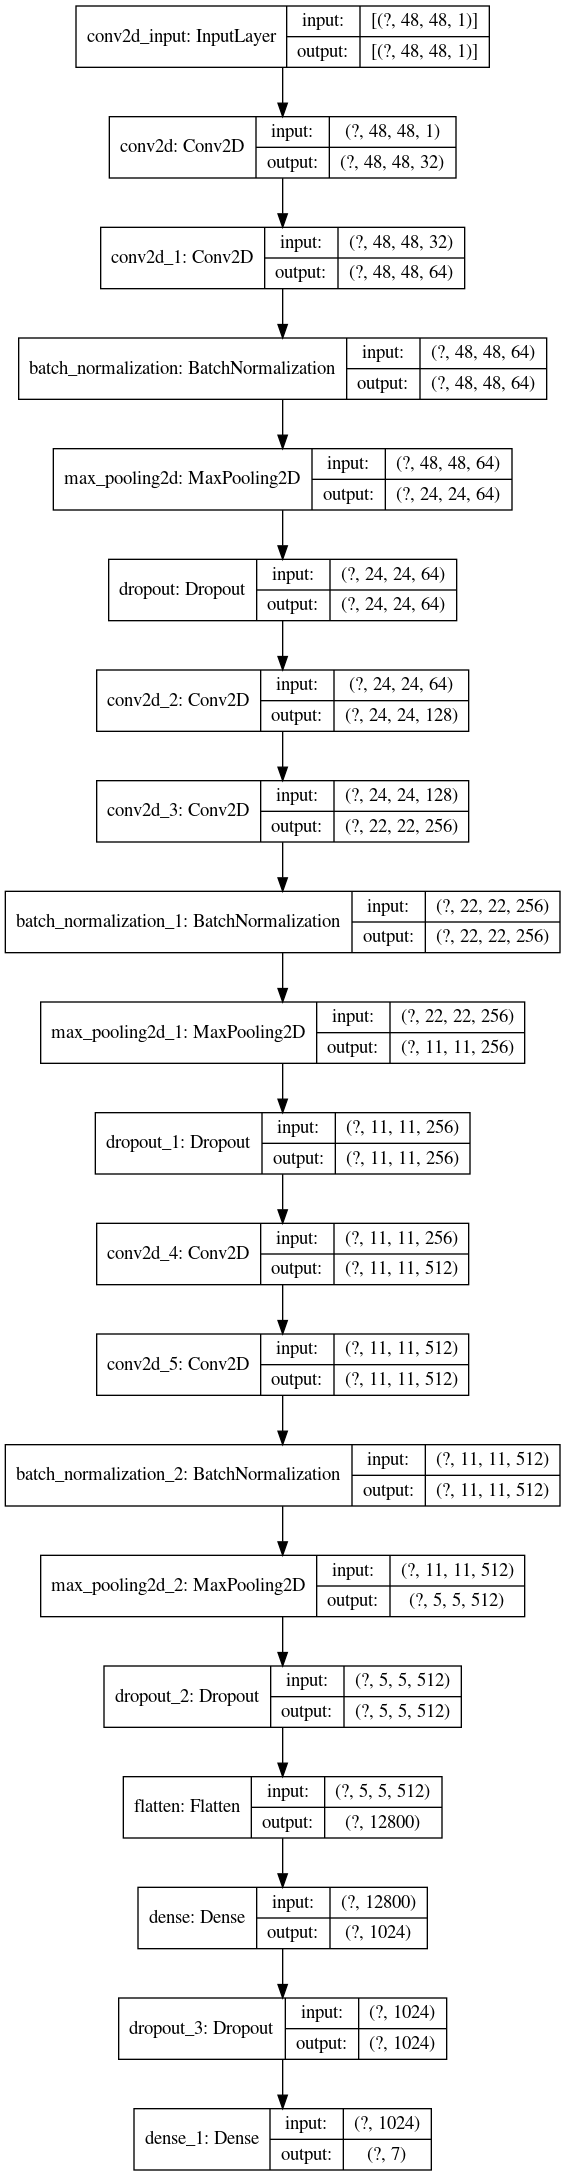

In [9]:
plot_model(fernet,
           to_file='fernet.png',
           show_shapes=True,
           show_layer_names=True)

In [10]:
#Callback functions

chk_path = 'ferNet.h5'
log_dir = 'checkpoint/logs/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
csv_logger = CSVLogger('training_log')

callbacks = [checkpoint,reduce_lr,csv_logger]

In [11]:
#training model

# print(training_set.n,training_set.batch_size)
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = testing_set.n // testing_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=testing_set,
                 epochs=100,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/100
448/448 [==============================] - ETA: 0s - loss: 12.1310 - accuracy: 0.2583
Epoch 00001: val_loss improved from inf to 13.00458, saving model to ferNet.h5
448/448 [==============================] - 203s 454ms/step - loss: 12.1310 - accuracy: 0.2583 - val_loss: 13.0046 - val_accuracy: 0.1759
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 9.3592 - accuracy: 0.3179
Epoch 00002: val_loss improved from 13.00458 to 8.07938, saving model to ferNet.h5
448/448 [==============================] - 39s 88ms/step - loss: 9.3592 - accuracy: 0.3179 - val_loss: 8.0794 - val_accuracy: 0.3740
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 6.9664 - accuracy: 0.3491
Epoch 00003: val_loss improved from 8.07938 to 5.94500, saving model to ferNet.h5
448/448 [==============================] - 39s 88ms/step - loss: 6.9664 - accuracy: 0.3491 - val_loss: 5.9450 - val_accuracy: 0.4037
Epoch 4/100
448/448 [==============================] - ETA: 0

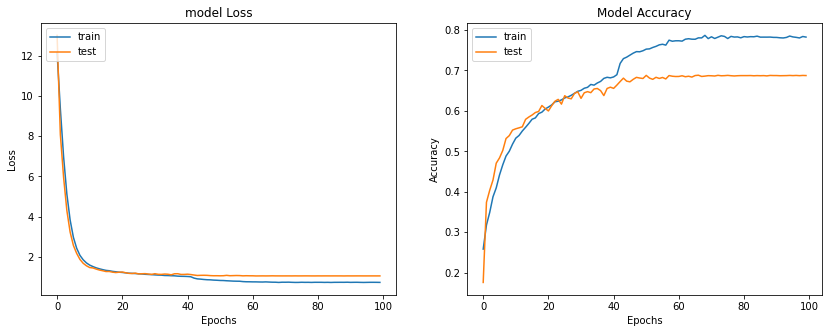

In [12]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(testing_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 5s 46ms/step - loss: 1.0629 - accuracy: 0.6874
final train accuracy = 84.35 , validation accuracy = 68.74


In [14]:
fernet.save_weights('fernet_bestweight.h5')

Confusion Matrix
[[ 534   47  508 1021  780  672  433]
 [  65    6   50  126   78   62   49]
 [ 524   59  503 1059  790  695  467]
 [ 974  108  917 1774 1354 1283  805]
 [ 685   70  567 1261  969  843  570]
 [ 638   59  632 1327  867  809  498]
 [ 429   41  388  821  606  513  373]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.14      3995
     disgust       0.02      0.01      0.01       436
        fear       0.14      0.12      0.13      4097
       happy       0.24      0.25      0.24      7215
     neutral       0.18      0.20      0.19      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.12      0.12      0.12      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



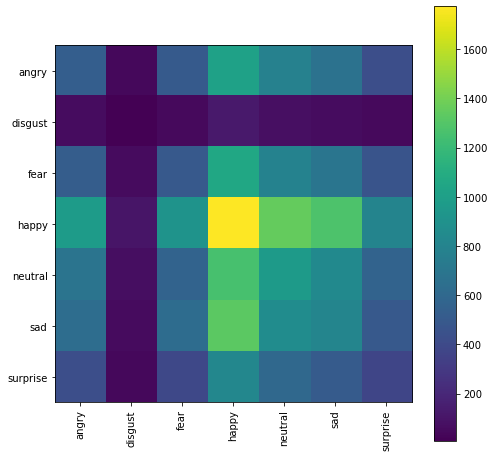

In [15]:
#Confusion Matrix and Classification on training set

y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = testing_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)


Confusion Matrix
[[145  11 122 232 189 150 109]
 [ 15   0  15  24  22  23  12]
 [141  17 119 263 195 176 113]
 [264  20 192 424 363 311 200]
 [167   3 135 321 244 229 134]
 [165  19 163 328 237 191 144]
 [106   8 101 189 176 151 100]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.15       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.12      0.13      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.17      0.20      0.18      1233
         sad       0.16      0.15      0.15      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



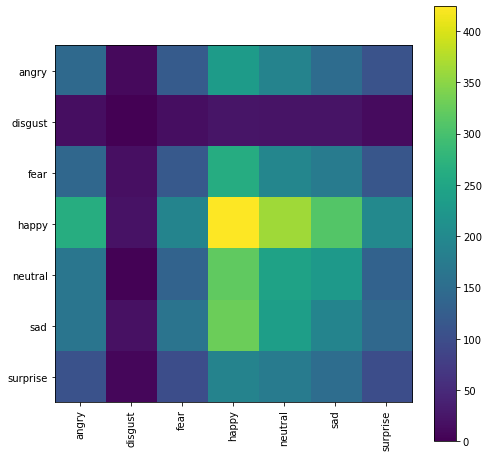

In [16]:
#Confusion Matrix and Classification on test set

y_pred = fernet.predict(testing_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = testing_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(testing_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(testing_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)